# Medical Insurance Regression Project
## 의료 보험비 회귀 예측
https://www.kaggle.com/datasets/mirichoi0218/insurance/data

<br>

#### feature (6개)
- age: 주요 수혜자의 나이
- sex: 보험계약자 성별, 여성, 남성
- bmi: 신체에 대한 이해를 제공하는 체질량지수  
  <sub>키에 비해 상대적으로 높거나 낮은 체중, 신장과 체중의 비율을 이용한 객관적인 체중지수(kg/m^2)</sub>  
  <sub>이상적으로는 18.5~24.9</sub>
- children : 건강보험 적용 자녀 수 / 부양가족 수
- smoker: 흡연
- region: 미국 내 수혜자의 주거 지역, 북동부, 남동부, 남서부, 북서부.

<br>

#### target
- charges : 건강보험에서 청구하는 개인의료비

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# 컬러맵 가져오기
cmap = plt.get_cmap('Pastel1')

# 한글 폰트 경로 설정
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [2]:
import pandas as pd

# 데이터 세트 호출
m_df = pd.read_csv('./datasets/medical_insurance.csv', low_memory=False)
m_df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
2767,47,female,45.320,1,no,southeast,8569.86180
2768,21,female,34.600,0,no,southwest,2020.17700
2769,19,male,26.030,1,yes,northwest,16450.89470
2770,23,male,18.715,0,no,northwest,21595.38229


### 🌟 1Cycle

#### 📊 데이터 전처리

In [3]:
# 중복행 제거
pre_m_df = m_df.drop_duplicates().reset_index(drop=True)

In [4]:
# 타겟 데이터 이상치 제거
from sklearn.preprocessing import StandardScaler

# 표준화 객체 생성
std = StandardScaler()
# 데이터 표준화 변환
result = std.fit_transform(pre_m_df[['charges']])
# 표준화 데이터 프레임 생성
std_pre_m_df = pd.DataFrame(result, columns=['charges'])

# 타겟 데이터 이상치 제거
std_pre_m_df = std_pre_m_df[std_pre_m_df.charges.between(-1.96, 1.96)]

# 이상치 제거후 유지되는 인덱스를 대조하여 원본 데이터 이상치 제거
pre_m_df = pre_m_df.iloc[std_pre_m_df.index].reset_index(drop=True)

In [5]:
# 타겟 컬럼 분포 변환
from sklearn.preprocessing import PowerTransformer

ptf = PowerTransformer(standardize=False)
pre_m_df['charges'] = ptf.fit_transform(pre_m_df[['charges']])

In [6]:
from sklearn.preprocessing import LabelEncoder

# 데이터 프레임 복제
enc_m_df = pre_m_df.copy()
encoders = {}

# 문자열 컬럼 추출
columns = ['sex', 'smoker']

# 반복하여 컬럼 인코딩 처리:
for column in columns:
    # 레이블인코더 객체 생성
    encoder = LabelEncoder()
    # 문자열 데이터 정수로 형변환
    result = encoder.fit_transform(enc_m_df[column])
    # 형변환 값으로 대체
    enc_m_df[column] = result
    # 원본 데이터 담기
    encoders[column] = encoder.classes_

In [7]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# 원 핫 인코더 객체 생성
# sparse_output: False = 밀집행렬(실제 값으로 채워진 행렬) 반환
one_hot_encoder = OneHotEncoder(sparse_output=False)
# 지역 피처 인코딩 처리
result = one_hot_encoder.fit_transform(enc_m_df[['region']])

# 인코딩 값 데이터 프레임으로 생성하고 정수로 형변환한 뒤, 기존 데이터 프레임과 병합
enc_m_df = pd.concat([enc_m_df, pd.DataFrame(result, columns=one_hot_encoder.categories_).astype(np.int8)], axis=1)

# 사용이 끝난 데이터 제거
enc_m_df = enc_m_df.drop(labels='region', axis=1)

# 원 핫 인코딩 컬럼명 변경
enc_m_df.rename(columns={
    ('northeast',): 'northeast',
    ('northwest',): 'northwest',
    ('southeast',): 'southeast',
    ('southwest',): 'southwest',
}, inplace=True)

In [8]:
# 타겟 컬럼 위치 변경을 위해 새로운 컬럼에 데이터 담기
enc_m_df['target'] = enc_m_df.charges
# 기존 컬럼은 제거
enc_m_df = enc_m_df.drop(labels='charges', axis=1)

#### 🚩 1Cycle 결과
- 선형 회귀  
**MSE: 2.0043, RMSE: 1.4158, MSLE: 0.0052, RMSLE: 0.0720, R2: 0.7340**

- 다중 회귀  
**MSE: 2.2306, RMSE: 1.4935, MSLE: 0.0060, RMSLE: 0.0774, R2: 0.7040**

- 회귀 모델(GradientBoostingRegressor)  
**MSE: 1.9586, RMSE: 1.3995, MSLE: 0.0053, RMSLE: 0.0727, R2: 0.7401**

#### 💡 분석
- 선형 회귀 분석 결과 R2 점수가 0.7340으로 나타났으며, 다중 회귀 분석 결과 R2점수가 0.7040로 나타나서 선형 패턴을 지니고 있다고 판단됨.  
  다만, 회귀 모델 분석 시 R2 점수가 0.74로 상승함에 따라 완전한 선형은 아니고 비선형의 패턴도 띄고 있음을 확인함.
- 회귀 모델 중 GradientBoostingRegressor을 사용하였을 때, 가장 좋은 성능을 보임에 따라 해당 모델을 선택하는 것이 적합하다고 판단됨.

---

### 🌟 2Cycle
OLS, VIF, 상관관계 등 다양한 지표 확인 후 전처리

In [9]:
# 피처 제거
columns = ['northeast', 'northwest', 'southeast', 'southwest', 'sex']

enc_m_df = enc_m_df.drop(columns=columns, axis=1)

#### 🚩 1Cycle 결과
- 회귀 모델(GradientBoostingRegressor)  
**MSE: 1.9586, RMSE: 1.3995, MSLE: 0.0053, RMSLE: 0.0727, R2: 0.7401**

#### 🚩 2Cycle 결과
- 전처리 후 회귀 모델(GradientBoostingRegressor)  
**MSE: 2.0182, RMSE: 1.4206, MSLE: 0.0054, RMSLE: 0.0733, R2: 0.7322**

#### 💡 분석
- 상관관계가 낮은 피처 제거 후 성능이 매우 근소한 차이로 저하된 것을 확인하였지만, 다중 공산성을 해결하기 위해 제거하기로 함.
- validation 분리 후 훈련하여 성능평가를 재진행하기로 함.

---

### 🌟 3Cycle
K-Fold, GridSearchCV를 통한 교차검증

#### 🚩 2Cycle 결과
- 전처리 후 회귀 모델(GradientBoostingRegressor)  
**MSE: 2.0182, RMSE: 1.4206, MSLE: 0.0054, RMSLE: 0.0733, R2: 0.7322**
  
#### 🚩 3Cycle 결과
- K-Fold  
**MSE: 1.8234, RMSE: 1.3503, MSLE: 0.0048, RMSLE: 0.0694, R2: 0.7581**

#### 💡 분석
- validation 후 성능이 더 향상된 것으로 나타났으며, 5-폴드보다 k-폴드의 성능이 근소한 차이로 열세한 것으로 나타남.
- 차원 축소 시 성능이 어떻게 조정되는지 확인하기로 함.

---

### 🌟 4Cycle
PCA 차원 축소

#### 🚩 3Cycle 결과
- K-Fold  
**MSE: 1.8234, RMSE: 1.3503, MSLE: 0.0048, RMSLE: 0.0694, R2: 0.7581**

#### 🚩 4Cycle 결과
- 차원축소 (3차원)  
**MSE: 5.0420, RMSE: 2.2454, MSLE: 0.0134, RMSLE: 0.1156, R2: 0.3310**

#### 💡 분석
- 차원 축소 시 성능이 훨씬 저하된다는 것을 확인함.
- 정규화 추가 진행 후 성능이 어떻게 변화하는지 더 확인해 보기로 함.

---

### 🌟 5Cycle
정규화 및 PCA 차원 축소

#### 🚩 3Cycle 결과
- K-Fold  
**MSE: 1.8234, RMSE: 1.3503, MSLE: 0.0048, RMSLE: 0.0694, R2: 0.7581**

#### 🚩 4Cycle 결과
- 차원축소 (3차원)  
**MSE: 5.0420, RMSE: 2.2454, MSLE: 0.0134, RMSLE: 0.1156, R2: 0.3310**

#### 🚩 5Cycle 결과
- 정규화 처리 후 차원축소 (3차원)  
**MSE: 2.1856, RMSE: 1.4784, MSLE: 0.0060, RMSLE: 0.0774, R2: 0.7100**

#### 💡 분석
- 전처리 후 성능이 더 향상은 되었으나, 차원 축소 전 성능이 훨씬 우세하다는 것을 확인함.
- 과적합 여부를 확인하여 규제 적용 여부를 판단해야 함.

---

### 🌟 6Cycle
과적합 확인 후 규제 여부 판단

In [10]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score

def get_evaluation(y_test, prediction):
    MSE = mean_squared_error(y_test, prediction)
    RMSE = np.sqrt(MSE)
    MSLE = mean_squared_log_error(y_test, prediction)
    RMSLE = np.sqrt(MSLE)
    R2 = r2_score(y_test, prediction)
    print('MSE: {:.4f}, RMSE: {:.4f}, MSLE: {:.4f}, RMSLE: {:.4f}, R2: {:.4f}'\
         .format(MSE, RMSE, MSLE, RMSLE, R2))

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# 데이터 세트 분리
# 피처, 타겟 데이터 분리
features, targets = enc_m_df.iloc[:, :-1], enc_m_df.iloc[:, -1]

# 학습/테스트 및 문제/정답 데이터 세트 분리
X_train, X_test, y_train, y_test = \
train_test_split(features, targets, test_size=0.2, random_state=124)

# 검증 데이터 분리
val_X_train, val_X_test, val_y_train, val_y_test = \
train_test_split(X_train, y_train, test_size=0.2, random_state=124)

# 가장 성능으로 높았던 모델 가져오기
gb_r = GradientBoostingRegressor(random_state=124)

# 파라미터 값 조정
parameters = {'max_depth': [3, 4, 5], 'min_samples_split': [50, 60, 70], 'n_estimators': [40, 50, 60]}

# 교차검증
# n_splits: 데이터를 몇 개의 폴드로 나눌지를 결정 (일반적으로 5 또는 10)
# shuffle: 분할 전 데이터 혼합 여부 
kfold = KFold(n_splits=10, random_state=124, shuffle=True)

# 하이퍼 파라미터 조정
grid_cv_gb_r = GridSearchCV(gb_r, param_grid=parameters, cv=kfold, n_jobs=-1)

# 훈련
grid_cv_gb_r.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=124, shuffle=True),
             estimator=GradientBoostingRegressor(random_state=124), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5],
                         'min_samples_split': [50, 60, 70],
                         'n_estimators': [40, 50, 60]})

In [12]:
# 훈련 결과 확인
result_df = pd.DataFrame(grid_cv_gb_r.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]
result_df

,params,mean_test_score,rank_test_score
0,"{'max_depth': 3, 'min_samples_split': 50, 'n_e...",0.755521,7
1,"{'max_depth': 3, 'min_samples_split': 50, 'n_e...",0.756100,2
2,"{'max_depth': 3, 'min_samples_split': 50, 'n_e...",0.755243,9
3,"{'max_depth': 3, 'min_samples_split': 60, 'n_e...",0.756137,1
4,"{'max_depth': 3, 'min_samples_split': 60, 'n_e...",0.755908,3
5,"{'max_depth': 3, 'min_samples_split': 60, 'n_e...",0.755595,6
6,"{'max_depth': 3, 'min_samples_split': 70, 'n_e...",0.755799,4
7,"{'max_depth': 3, 'min_samples_split': 70, 'n_e...",0.755664,5
8,"{'max_depth': 3, 'min_samples_split': 70, 'n_e...",0.755351,8
9,"{'max_depth': 4, 'min_samples_split': 50, 'n_e...",0.752425,11


In [13]:
result_df[result_df.rank_test_score == 1]['params'].values

array([{'max_depth': 3, 'min_samples_split': 60, 'n_estimators': 40}],
      dtype=object)

In [14]:
# 최적의 모델
o_gb_r = grid_cv_gb_r.best_estimator_

In [15]:
# 예측
prediction = o_gb_r.predict(X_train)

# 평가
get_evaluation(y_train, prediction)

MSE: 2.0431, RMSE: 1.4294, MSLE: 0.0051, RMSLE: 0.0716, R2: 0.7872


In [16]:
# 최적의 모델
val_gb_r = grid_cv_gb_r.best_estimator_

# 예측
prediction = val_gb_r.predict(val_X_train)

# 평가
get_evaluation(val_y_train, prediction)

MSE: 2.2096, RMSE: 1.4865, MSLE: 0.0055, RMSLE: 0.0743, R2: 0.7699


In [17]:
# 최적의 모델
t_gb_r = grid_cv_gb_r.best_estimator_

# 예측
prediction = t_gb_r.predict(X_test)

# 평가
get_evaluation(y_test, prediction)

MSE: 1.8234, RMSE: 1.3503, MSLE: 0.0048, RMSLE: 0.0694, R2: 0.7581


In [18]:
f_data = {
    'model': ['train', 'val_train', 'test'],
    'R2': [0.7872, 0.7699, 0.7581],
}

f_df = pd.DataFrame(f_data)

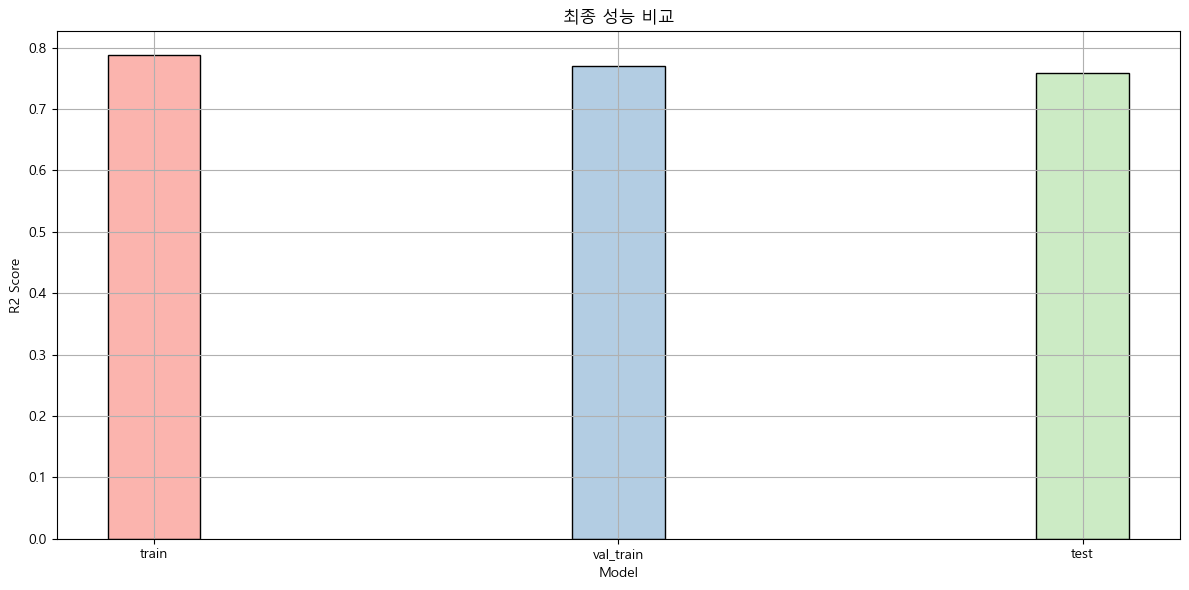

,model,R2
0,train,0.7872
1,val_train,0.7699
2,test,0.7581


In [19]:
import matplotlib.pyplot as plt
import numpy as np

# 그래프 그리기
plt.figure(figsize=(12, 6))

# 컬러맵 가져오기
cmap = plt.get_cmap('Pastel1')

plt.bar(f_df['model'], f_df['R2'], color=cmap(np.array([0, 1, 2])), edgecolor='black', width=0.2)
plt.title('최종 성능 비교')
plt.xlabel('Model')
plt.ylabel('R2 Score')
plt.grid(True)

# # y축의 범위 지정
# plt.ylim(0.8, 0.85)

plt.tight_layout()
plt.show()

display(f_df)

#### 📊 cross val score

In [20]:
from sklearn.model_selection import cross_val_score

# 점수 확인
score = cross_val_score(o_gb_r, features, targets)
score

array([0.81853009, 0.65259246, 0.82374275, 0.75693076, 0.74001037])

MSE: 2.0431, RMSE: 1.4294, MSLE: 0.0051, RMSLE: 0.0716, R2: 0.7872
MSE: 2.2096, RMSE: 1.4865, MSLE: 0.0055, RMSLE: 0.0743, R2: 0.7699
MSE: 1.8234, RMSE: 1.3503, MSLE: 0.0048, RMSLE: 0.0694, R2: 0.7581


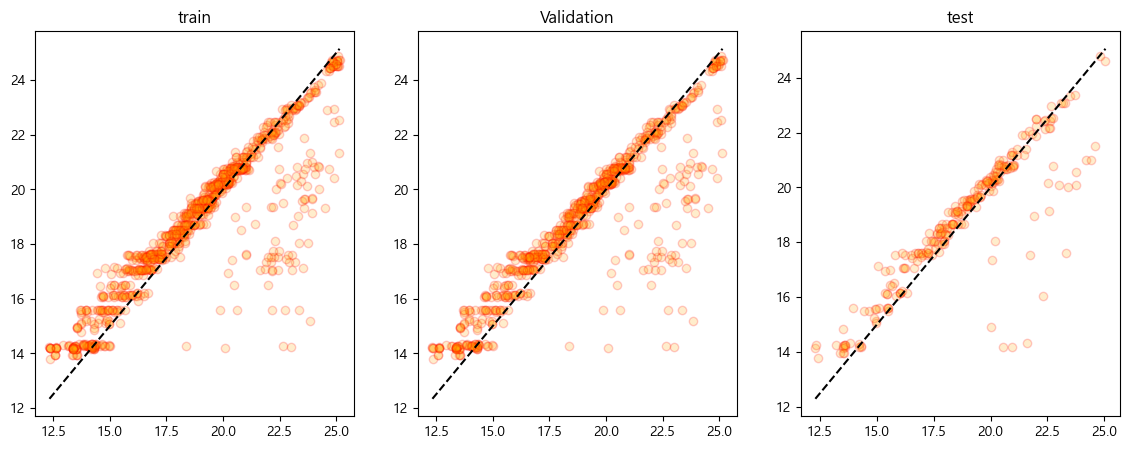

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(14, 5))

# 최적의 모델
o_gb_r = grid_cv_gb_r.best_estimator_
# 예측
prediction = o_gb_r.predict(X_train)
# 평가
get_evaluation(y_train, prediction)

ax[0].scatter(y_train, prediction, edgecolors='red', c='orange', alpha=0.2)
ax[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--')
ax[0].set_title('train')

# 최적의 모델
val_gb_r = grid_cv_gb_r.best_estimator_
# 예측
prediction = val_gb_r.predict(val_X_train)
# 평가
get_evaluation(val_y_train, prediction)

ax[1].scatter(val_y_train, prediction, edgecolors='red', c='orange', alpha=0.2)
ax[1].plot([val_y_train.min(), val_y_train.max()], [val_y_train.min(), val_y_train.max()], 'k--')
ax[1].set_title('Validation')

# 최적의 모델
t_gb_r = grid_cv_gb_r.best_estimator_
# 예측
prediction = t_gb_r.predict(X_test)
# 평가
get_evaluation(y_test, prediction)

ax[2].scatter(y_test, prediction, edgecolors='red', c='orange', alpha=0.2)
ax[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
ax[2].set_title('test')

plt.show()

#### 📊 torch

In [22]:
import torch
from sklearn.model_selection import train_test_split
from torch.nn import Linear
from torch.nn.functional import mse_loss
from torch.optim import SGD

# 랜덤 값 지정
torch.manual_seed(124)

# 데이터 세트 분리
# 피처, 타겟 데이터 분리
features, targets = enc_m_df.iloc[:, :-1], enc_m_df.iloc[:, -1]

# 문제/정답 및 학습/훈련 데이터 분리
X_train, X_test, y_train, y_test = \
train_test_split(features, targets, test_size=0.2, random_state=124)

# 검증 데이터 분리
val_X_train, val_X_test, val_y_train, val_y_test = \
train_test_split(X_train, y_train, test_size=0.2, random_state=124)

# 텐서로 변경 (차원 조정)
X_train = torch.FloatTensor(X_train.values)
y_train = torch.FloatTensor(y_train.values).view(-1, 1)

X_test = torch.FloatTensor(X_test.values)
y_test = torch.FloatTensor(y_test.values).view(-1, 1)

val_X_train = torch.FloatTensor(val_X_train.values)
val_y_train = torch.FloatTensor(val_y_train.values).view(-1, 1)

val_X_test = torch.FloatTensor(val_X_test.values)
val_y_test = torch.FloatTensor(val_y_test.values).view(-1, 1)

# 선형 회귀 모델
l_r_train = Linear(4, 1)
l_r_val = Linear(4, 1)
l_r_test = Linear(4, 1)

# 경사 하강법 (최적화 알고리즘)
optimizer_train = SGD(l_r_train.parameters(), lr=1e-4)
optimizer_val = SGD(l_r_train.parameters(), lr=1e-4)
optimizer_test = SGD(l_r_test.parameters(), lr=1e-4)

# loss list
train_loss_box = []
val_loss_box = []
test_loss_box = []

In [23]:
# 반복 횟수
epochs = 850000

for epoch in range(1, epochs + 1):
    # 가설 선언
    H = l_r_train(val_X_train)
    # 손실 함수
    train_loss = mse_loss(H, val_y_train)

    # 다음 기울기를 위해 기존 기울기 초기화
    optimizer_train.zero_grad()
    # 손실 함수 미분 후 기울기 계산
    train_loss.backward()
    # W, b 업데이트
    optimizer_train.step()

    # 출력
    if epoch % 1000 == 0:
        train_loss_box.append(train_loss.item())
        
        print('{:4d}/{}: '\
              .format(epoch, epochs, l_r_train.weight[0][0].item(), l_r_train.bias[0].item(), train_loss.item()), end='')
        for i, w in enumerate(list(l_r_train.parameters())[0][0]):
            print('W{}: {:.4f}, '\
                  .format(i + 1, w.item()), end='')
        print('b: {:.4f}, loss: {:.4f}'.format(list(l_r_train.parameters())[1].item(), train_loss.item()))

1000/850000: W1: 0.1844, W2: 0.3573, W3: 0.4087, W4: 0.1598, b: 0.1135, loss: 13.6685
2000/850000: W1: 0.1836, W2: 0.3532, W3: 0.4512, W4: 0.3394, b: 0.2047, loss: 13.2441
3000/850000: W1: 0.1829, W2: 0.3494, W3: 0.4822, W4: 0.5142, b: 0.2945, loss: 12.8480
4000/850000: W1: 0.1822, W2: 0.3459, W3: 0.5046, W4: 0.6844, b: 0.3830, loss: 12.4750
5000/850000: W1: 0.1817, W2: 0.3426, W3: 0.5207, W4: 0.8499, b: 0.4702, loss: 12.1220
6000/850000: W1: 0.1811, W2: 0.3395, W3: 0.5321, W4: 1.0111, b: 0.5562, loss: 11.7870
7000/850000: W1: 0.1806, W2: 0.3364, W3: 0.5400, W4: 1.1679, b: 0.6411, loss: 11.4684
8000/850000: W1: 0.1801, W2: 0.3335, W3: 0.5455, W4: 1.3205, b: 0.7248, loss: 11.1650
9000/850000: W1: 0.1797, W2: 0.3307, W3: 0.5490, W4: 1.4689, b: 0.8074, loss: 10.8760
10000/850000: W1: 0.1793, W2: 0.3280, W3: 0.5512, W4: 1.6134, b: 0.8890, loss: 10.6006
11000/850000: W1: 0.1788, W2: 0.3253, W3: 0.5523, W4: 1.7540, b: 0.9696, loss: 10.3379
12000/850000: W1: 0.1784, W2: 0.3227, W3: 0.5527, W4

In [24]:
# # 반복 횟수
# epochs = 850000

# for epoch in range(1, epochs + 1):
#     # 가설 선언
#     H = l_r_val(val_X_test)
#     # 손실 함수
#     val_loss = mse_loss(H, val_y_test)

#     # 다음 기울기를 위해 기존 기울기 초기화
#     optimizer_val.zero_grad()
#     # 손실 함수 미분 후 기울기 계산
#     val_loss.backward()
#     # W, b 업데이트
#     optimizer_val.step()

#     # 출력
#     if epoch % 1000 == 0:
#         val_loss_box.append(val_loss.item())
        
#         print('{:4d}/{}: '\
#               .format(epoch, epochs, l_r_val.weight[0][0].item(), l_r_val.bias[0].item(), val_loss.item()), end='')
#         for i, w in enumerate(list(l_r_val.parameters())[0][0]):
#             print('W{}: {:.4f}, '\
#                   .format(i + 1, w.item()), end='')
#         print('b: {:.4f}, loss: {:.4f}'.format(list(l_r_val.parameters())[1].item(), val_loss.item()))

1000/850000: W1: -0.3769, W2: -0.1903, W3: -0.0335, W4: -0.0153, b: -0.2783, loss: 1588.5396
2000/850000: W1: -0.3769, W2: -0.1903, W3: -0.0335, W4: -0.0153, b: -0.2783, loss: 1588.5396
3000/850000: W1: -0.3769, W2: -0.1903, W3: -0.0335, W4: -0.0153, b: -0.2783, loss: 1588.5396
4000/850000: W1: -0.3769, W2: -0.1903, W3: -0.0335, W4: -0.0153, b: -0.2783, loss: 1588.5396
5000/850000: W1: -0.3769, W2: -0.1903, W3: -0.0335, W4: -0.0153, b: -0.2783, loss: 1588.5396
6000/850000: W1: -0.3769, W2: -0.1903, W3: -0.0335, W4: -0.0153, b: -0.2783, loss: 1588.5396
7000/850000: W1: -0.3769, W2: -0.1903, W3: -0.0335, W4: -0.0153, b: -0.2783, loss: 1588.5396
8000/850000: W1: -0.3769, W2: -0.1903, W3: -0.0335, W4: -0.0153, b: -0.2783, loss: 1588.5396
9000/850000: W1: -0.3769, W2: -0.1903, W3: -0.0335, W4: -0.0153, b: -0.2783, loss: 1588.5396
10000/850000: W1: -0.3769, W2: -0.1903, W3: -0.0335, W4: -0.0153, b: -0.2783, loss: 1588.5396
11000/850000: W1: -0.3769, W2: -0.1903, W3: -0.0335, W4: -0.0153, b: 

In [25]:
# 반복 횟수
epochs = 850000

for epoch in range(1, epochs + 1):
    # 가설 선언
    H = l_r_test(X_test)
    # 손실 함수
    test_loss = mse_loss(H, y_test)

    # 다음 기울기를 위해 기존 기울기 초기화
    optimizer_test.zero_grad()
    # 손실 함수 미분 후 기울기 계산
    test_loss.backward()
    # W, b 업데이트
    optimizer_test.step()

    # 출력
    if epoch % 1000 == 0:
        test_loss_box.append(test_loss.item())
        
        print('{:4d}/{}: '\
              .format(epoch, epochs, l_r_test.weight[0][0].item(), l_r_test.bias[0].item(), test_loss.item()), end='')
        for i, w in enumerate(list(l_r_test.parameters())[0][0]):
            print('W{}: {:.4f}, '\
                  .format(i + 1, w.item()), end='')
        print('b: {:.4f}, loss: {:.4f}'.format(list(l_r_test.parameters())[1].item(), test_loss.item()))

1000/850000: W1: 0.2077, W2: 0.3134, W3: 0.5854, W4: 0.5674, b: -0.1541, loss: 10.6336
2000/850000: W1: 0.2066, W2: 0.3096, W3: 0.6407, W4: 0.7095, b: -0.0637, loss: 10.3191
3000/850000: W1: 0.2057, W2: 0.3061, W3: 0.6818, W4: 0.8478, b: 0.0253, loss: 10.0313
4000/850000: W1: 0.2049, W2: 0.3030, W3: 0.7120, W4: 0.9827, b: 0.1130, loss: 9.7632
5000/850000: W1: 0.2041, W2: 0.3001, W3: 0.7337, W4: 1.1142, b: 0.1995, loss: 9.5106
6000/850000: W1: 0.2034, W2: 0.2973, W3: 0.7491, W4: 1.2424, b: 0.2848, loss: 9.2708
7000/850000: W1: 0.2028, W2: 0.2948, W3: 0.7596, W4: 1.3676, b: 0.3690, loss: 9.0420
8000/850000: W1: 0.2021, W2: 0.2923, W3: 0.7663, W4: 1.4898, b: 0.4522, loss: 8.8230
9000/850000: W1: 0.2015, W2: 0.2900, W3: 0.7702, W4: 1.6091, b: 0.5343, loss: 8.6131
10000/850000: W1: 0.2009, W2: 0.2878, W3: 0.7720, W4: 1.7255, b: 0.6154, loss: 8.4116
11000/850000: W1: 0.2004, W2: 0.2856, W3: 0.7721, W4: 1.8392, b: 0.6955, loss: 8.2180
12000/850000: W1: 0.1998, W2: 0.2835, W3: 0.7710, W4: 1.95

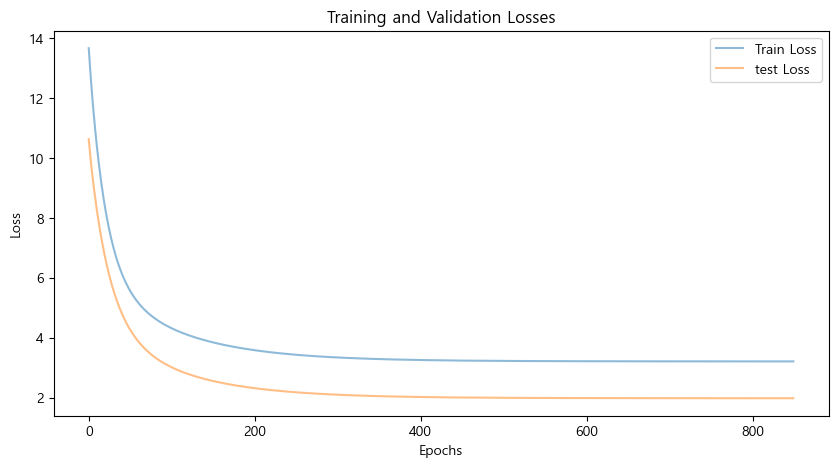

In [39]:
# 손실 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(train_loss_box, label='Train Loss', alpha=0.5)
# plt.plot(val_loss_box, label='Validation Loss', alpha=0.5)
plt.plot(test_loss_box, label='test Loss', alpha=0.5)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

#### 📊 lasso

In [40]:
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

features, targets = enc_m_df.iloc[:, :-1], enc_m_df.iloc[:, -1]

X_train, X_test, y_train, y_test = \
train_test_split(features, targets, test_size=0.2, random_state=124)

# 검증 데이터 분리
val_X_train, val_X_test, val_y_train, val_y_test = \
train_test_split(X_train, y_train, test_size=0.2, random_state=124)

lasso = Lasso(alpha=1, max_iter=10000)

lasso.fit(X_train, y_train)

Lasso(alpha=1, max_iter=10000)

MSE: 6.8438, RMSE: 2.6161, MSLE: 0.0175, RMSLE: 0.1321, R2: 0.2873
MSE: 6.9985, RMSE: 2.6455, MSLE: 0.0177, RMSLE: 0.1332, R2: 0.2712
MSE: 4.9650, RMSE: 2.2282, MSLE: 0.0132, RMSLE: 0.1147, R2: 0.3412


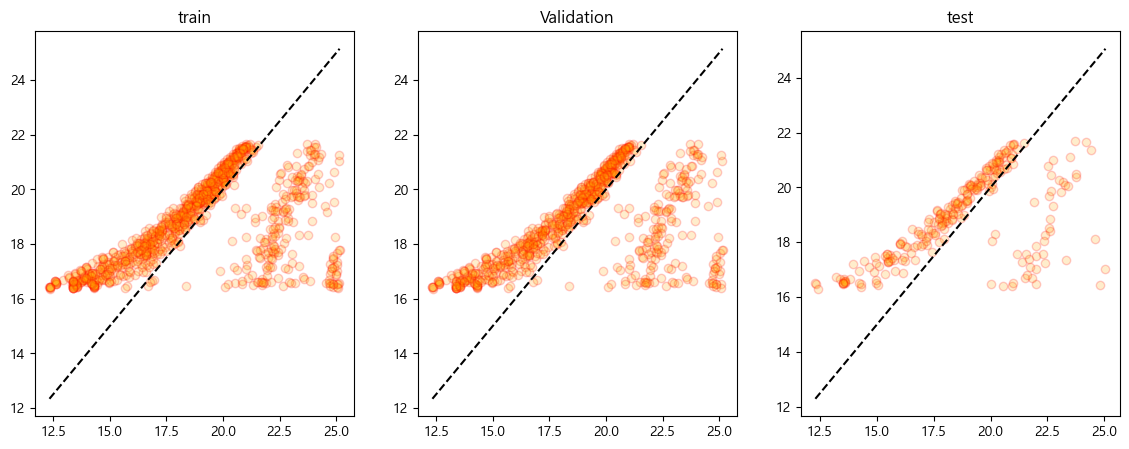

In [44]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(14, 5))

# 예측
prediction = lasso.predict(X_train)
# 평가
get_evaluation(y_train, prediction)

ax[0].scatter(y_train, prediction, edgecolors='red', c='orange', alpha=0.2)
ax[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--')
ax[0].set_title('train')

# 예측
prediction = lasso.predict(val_X_train)
# 평가
get_evaluation(val_y_train, prediction)

ax[1].scatter(val_y_train, prediction, edgecolors='red', c='orange', alpha=0.2)
ax[1].plot([val_y_train.min(), val_y_train.max()], [val_y_train.min(), val_y_train.max()], 'k--')
ax[1].set_title('Validation')

# 예측
prediction = lasso.predict(X_test)
# 평가
get_evaluation(y_test, prediction)

ax[2].scatter(y_test, prediction, edgecolors='red', c='orange', alpha=0.2)
ax[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
ax[2].set_title('test')

plt.show()

#### 📊 ridge

In [45]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

features, targets = enc_m_df.iloc[:, :-1], enc_m_df.iloc[:, -1]

X_trian, X_test, y_trian, y_test = \
train_test_split(features, targets, test_size=0.2, random_state=124)

# 검증 데이터 분리
val_X_train, val_X_test, val_y_train, val_y_test = \
train_test_split(X_train, y_train, test_size=0.2, random_state=124)

ridge = Ridge(alpha=1e+1, max_iter=10000)
ridge.fit(X_train, y_train)

Ridge(alpha=10.0, max_iter=10000)

MSE: 3.0788, RMSE: 1.7547, MSLE: 0.0076, RMSLE: 0.0872, R2: 0.6794
MSE: 3.2312, RMSE: 1.7976, MSLE: 0.0079, RMSLE: 0.0891, R2: 0.6635
MSE: 2.0125, RMSE: 1.4186, MSLE: 0.0053, RMSLE: 0.0728, R2: 0.7330


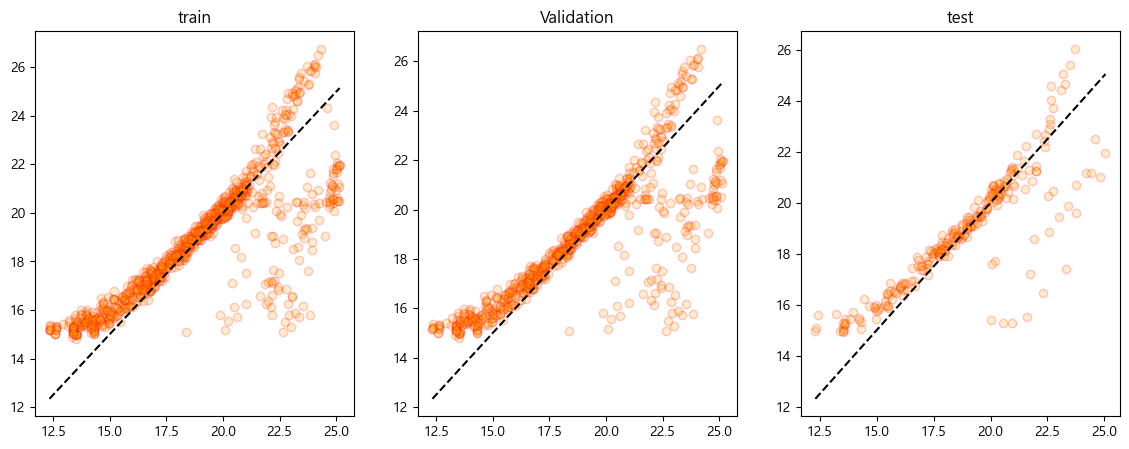

In [46]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(14, 5))

# 예측
prediction = ridge.predict(X_train)
# 평가
get_evaluation(y_train, prediction)

ax[0].scatter(y_train, prediction, edgecolors='red', c='orange', alpha=0.2)
ax[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--')
ax[0].set_title('train')

# 예측
prediction = ridge.predict(val_X_train)
# 평가
get_evaluation(val_y_train, prediction)

ax[1].scatter(val_y_train, prediction, edgecolors='red', c='orange', alpha=0.2)
ax[1].plot([val_y_train.min(), val_y_train.max()], [val_y_train.min(), val_y_train.max()], 'k--')
ax[1].set_title('Validation')

# 예측
prediction = ridge.predict(X_test)
# 평가
get_evaluation(y_test, prediction)

ax[2].scatter(y_test, prediction, edgecolors='red', c='orange', alpha=0.2)
ax[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
ax[2].set_title('test')

plt.show()